# **Meta 1**

Program started
Connected to remote API server
Número de objetos na simulação: 185
Erro ao obter as dimensões do objeto 0
Erro ao obter min_x para o objeto 1
Erro ao obter as dimensões do objeto 1
Erro ao obter min_x para o objeto 2
Erro ao obter as dimensões do objeto 2
Erro ao obter min_x para o objeto 3
Erro ao obter as dimensões do objeto 3
Erro ao obter min_x para o objeto 4
Erro ao obter as dimensões do objeto 4
Erro ao obter min_x para o objeto 5
Erro ao obter as dimensões do objeto 5
Erro ao obter min_x para o objeto 6
Erro ao obter as dimensões do objeto 6
Erro ao obter min_x para o objeto 7
Erro ao obter as dimensões do objeto 7
Erro ao obter as dimensões do objeto 8
Erro ao obter min_x para o objeto 9
Erro ao obter as dimensões do objeto 9
Erro ao obter min_x para o objeto 10
Erro ao obter as dimensões do objeto 10
Erro ao obter min_x para o objeto 11
Erro ao obter as dimensões do objeto 11
Erro ao obter min_x para o objeto 12
Erro ao obter as dimensões do objeto 12
Ignorand

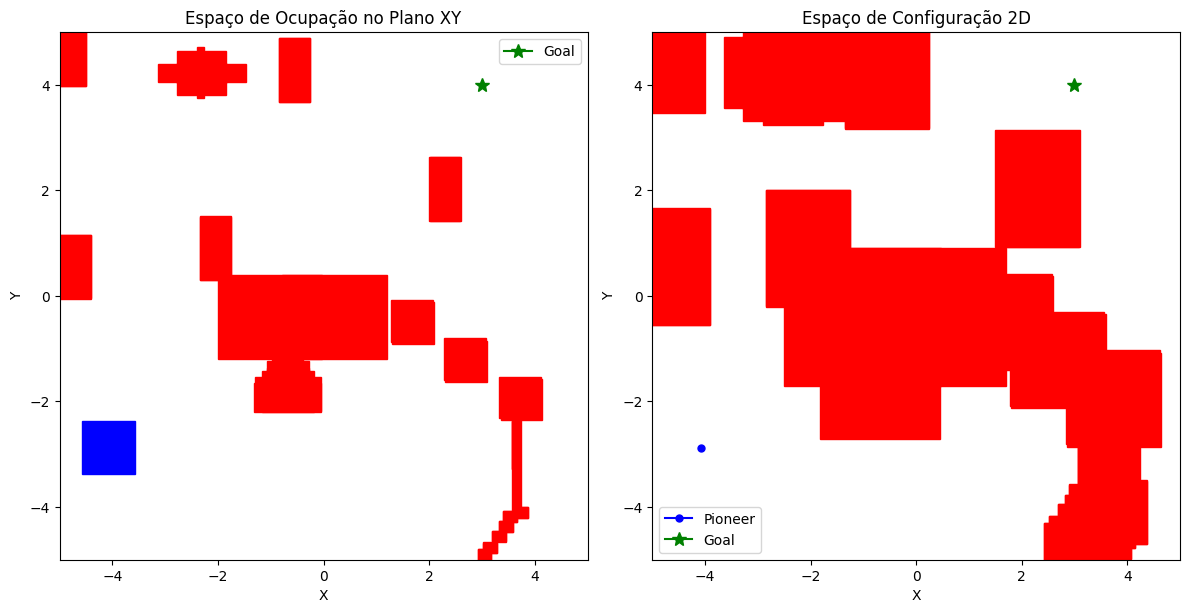

Program ended


In [2]:
from RobotLibrary import *

print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')
    controller = RobotController(clientID)

    controller.set_goal(np.array([3,4,0]))

    controller.get_map()

    controller.plot_map()
    
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')

print('Program ended')

# **Meta 2**

Program started
Connected to remote API server


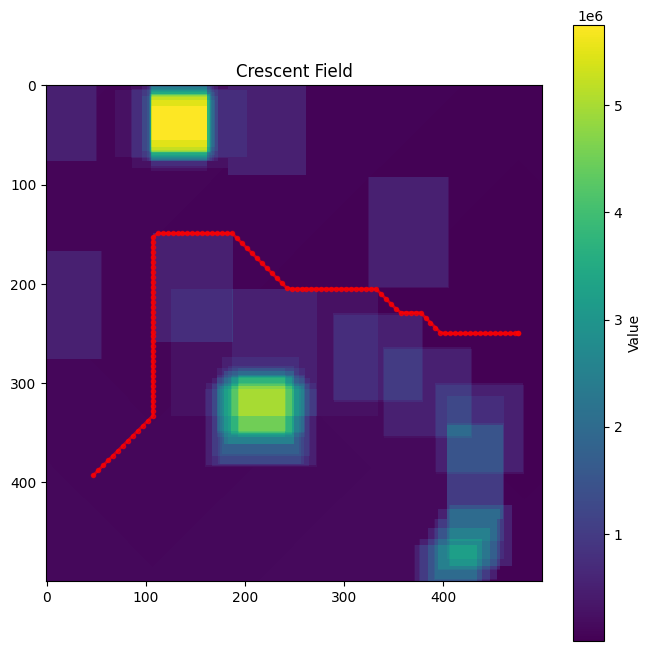

Program ended


In [4]:
from RobotLibrary import *

print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')

    controller.set_goal(np.array([4.5,0,0]))
    
    controller.get_generated_path_manha(True)

    # controller.send_generated_path()

    controller.control_loop(500)

    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')

print('Program ended')


